<div align="right"><i>Peter Norvig<br>16 December 2019</i></div>

# Predicting Presidential Electoral Votes from Approval Polls

Various sites aggregate opinion polls on presidential job performance. The polls are broken out state-by-state, month-by-month at [Mourning Consult](https://morningconsult.com/tracking-trump/). Trump's national **net approval** (percent approving minus percent disapproving) is currently  -10% on [RealClearPolitics](https://www.realclearpolitics.com/epolls/other/president_trump_job_approval-6179.html), -13% on  [538](https://projects.fivethirtyeight.com/trump-approval-ratings/), and -16% on [Gallup](https://news.gallup.com/poll/203198/presidential-approval-ratings-donald-trump.aspx).  There are four big caveats in jumping from these numbers to conclusions about the election:

1. Today is not election day 2020. 

2. We don't know who will be on the ballot in 2020.

3. Approval polls are not votes. 

4. Popular votes are not electoral votes. 

I have nothing to offer on the first three points. But can we use state-by-state approval polls to 
predict electoral votes? ***Yes we can!***


# TL;DR: Trump is at 185 Electoral Votes

As of November, 2019, Trump would get  **185** electoral votes under the assumption that he wins the electoral votes of states where he currently has positive net approval and loses the states where he has negative net approval. To win, he'd have to get to **270**, which would entail flipping 11 states (if you go in net approval order), the toughest of which would be Pennsylvania, where he is currently at **-9%** net approval.

# Details for data science nerds

View, verify, or modify **[my code](ElectoralVotesCode.ipynb)**.

In [1]:
%run ElectoralVotesCode.ipynb

EV(states)

185

# Details for policy wonks

The following plot shows, for each month in office, the expected number of electoral votes, with error bars indicating a 3% approval swing in either direction (that is: the blue diamond is the total number of electoral votes for states where he has net positive approval; the top and bottom of the grey bars give the total if he were to gain or lose 3% in every state. Why 3%? That was the [average error](https://fivethirtyeight.com/features/the-polls-are-all-right/) in national presidential polls in 2016: Clinton was predicted to win the popular vote by 6% but actually only won by 3%.) Trump hasn't been above 270 since 4 months into his term. He's been below 200 for a year.

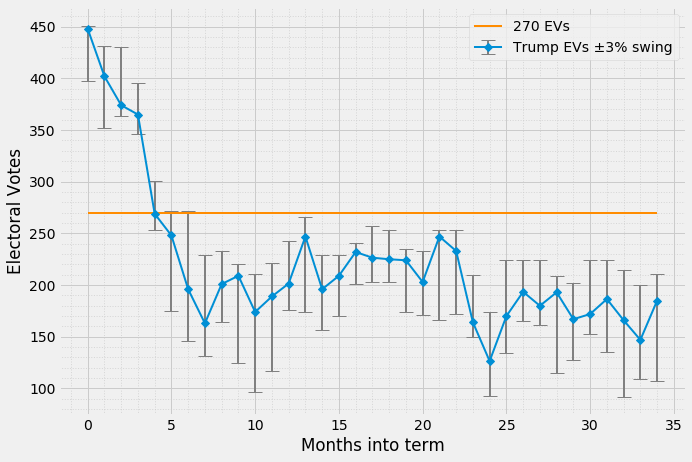

In [2]:
show_evs()

# Uncertainty

There's a lot of uncertainty. We don't know who  will be on the ballot and what their approval levels will be, we don't know if there is systematic bias in the polling data, we don't know who will decide not to vote, we don't know who will be prevented or dissuaded from voting by interference foreign or domestic, we don't know if future events will change voters' perceptions. In what follows, I assume there is no big event (or events) that makes a dramatic change in the public perception of candidates; rather, just the normal range of change in approval as tracked over the last 3 years of Trump's presidency. I have five ways of understanding the fluidity of the situation:

- **Undecided**: Undecided voters could make up their minds late in the election cycle. But there are few undecided voters: in most states, only 3% or 4%. 

- **Variance**: How much are voters changing their minds from month to month in each state?  I track the standard deviation, 𝝈, of the net approval for each state over the last 12 months (variance is the square of standard deviation).

- **Movement**: I define the **maximum expected movement** of approval as 1/5 of the undecided voters (i.e., assume the undecided voters broke 60/40 one way or the other) plus 2 standard deviations in the monthly net approval. 

- **Swing state**: I define a swing state as one whose maximum expected movement is greater than the absolute value of the net approval. There are **13** such states now, all with net approval between **+3% and -5%**.  The swing states are shown below in **BOLD CAPS**.

- **Margin**: If you list states in order of net approval, the key turning-point state is Pennsylvania; Trump would need to win that and every state in which he is more popular to reach 270. He currently is **7% behind in Pennsylvania**, so we say that his **margin is 7%**.

# State-by-state summary table

The following table packs in a lot of information. States are sorted by net approval. The columns are:

- **State**: name of state. 
- **Net**: President's current net approval in state.
- **Move**:  Expected maximum movement: 1/5 of the undecided voters  plus 2 standard deviations in the net approval over the last 12 months.
- **EV**: State's number of electoral votes.
- **ΣEV**: Cumulative running sum of electoral votes of this state and all states above.
- **+**: President's current approval in state.
- **-**: President's current disapproval in state.
- **?**: Undecideds in state.
- **𝝈**: Standard deviation in net approval over the past 12 months in state.

The table shows that:
- If Trump wins the states he is leading in, he gets **185** electoral votes (the **ΣEV** in the Florida row).
- If he also wins all the swing states, he gets **253** electoral votes (**ΣEV** in the Ohio row). 
- To get to **270**, going in order of states with least bad net approval, he would also need to win Ohio, Nevada, and Pennsylvania. Or substitute Virginia for one of these; but he would need to win at least one state where he is currently down by **7%**, so that's the margin.
- Some traditional swing states currently seem out of reach for Trump: he's at **-14%** in Michigan and  Wisconsin.


In [3]:
show_states()

|State|Net|Move|EV|ΣEV|+|−|?|𝝈|
|-|-|-|-|-|-|-|-|-|
|Wyoming|+35%|±11%|3|3|66%|31%|3%|±5.3%
|Alabama|+22%|±6%|9|12|59%|37%|4%|±2.5%
|Mississippi|+19%|±6%|6|18|57%|38%|5%|±2.7%
|West Virginia|+19%|±6%|5|23|58%|39%|3%|±2.7%
|Idaho|+18%|±6%|4|27|57%|39%|4%|±2.8%
|Tennessee|+16%|±5%|11|38|56%|40%|4%|±2.1%
|Kentucky|+14%|±4%|8|46|55%|41%|4%|±1.5%
|Alaska|+10%|±7%|3|49|53%|43%|4%|±3.1%
|Louisiana|+10%|±7%|8|57|53%|43%|4%|±2.9%
|Oklahoma|+9%|±6%|7|64|53%|44%|3%|±2.5%
|Arkansas|+8%|±5%|6|70|52%|44%|4%|±2.0%
|South Carolina|+8%|±4%|9|79|52%|44%|4%|±1.7%
|**KANSAS**|**+3%**|**±5%**|6|85|50%|47%|3%|±2.2%
|**MISSOURI**|**+3%**|**±6%**|10|95|50%|47%|3%|±2.7%
|**SOUTH DAKOTA**|**+3%**|**±9%**|3|98|50%|47%|3%|±4.1%
|**TEXAS**|**+3%**|**±4%**|38|136|49%|46%|5%|±1.5%
|**INDIANA**|**+2%**|**±4%**|11|147|49%|47%|4%|±1.8%
|**NORTH DAKOTA**|**+2%**|**±6%**|3|150|49%|47%|4%|±2.7%
|**UTAH**|**+2%**|**±7%**|6|156|49%|47%|4%|±3.1%
|**FLORIDA**|**+1%**|**±3%**|29|185|49%|48%|3%|±1.4%
|**MONTANA**|**-1%**|**±7%**|3|188|48%|49%|3%|±3.1%
|**NORTH CAROLINA**|**-2%**|**±4%**|15|203|47%|49%|4%|±1.5%
|**GEORGIA**|**-3%**|**±6%**|16|219|46%|49%|5%|±2.6%
|**ARIZONA**|**-4%**|**±4%**|11|230|46%|50%|4%|±1.7%
|**NEBRASKA**|**-5%**|**±9%**|5|235|46%|51%|3%|±4.1%
|Ohio|-5%|±3%|18|253|46%|51%|3%|±1.0%
|Nevada|-7%|±5%|6|259|45%|52%|3%|±2.3%
|Pennsylvania|-7%|±3%|20|279|45%|52%|3%|±1.2%
|Virginia|-7%|±4%|13|292|45%|52%|3%|±1.9%
|New Mexico|-9%|±7%|5|297|44%|53%|3%|±3.4%
|Iowa|-13%|±4%|6|303|42%|55%|3%|±1.8%
|Maine|-13%|±5%|4|307|42%|55%|3%|±2.4%
|Minnesota|-13%|±5%|10|317|42%|55%|3%|±2.1%
|Michigan|-14%|±4%|16|333|41%|55%|4%|±1.8%
|Wisconsin|-14%|±4%|10|343|41%|55%|4%|±1.7%
|Colorado|-15%|±5%|9|352|41%|56%|3%|±2.3%
|New Hampshire|-15%|±9%|4|356|41%|56%|3%|±4.1%
|New Jersey|-15%|±4%|14|370|41%|56%|3%|±1.5%
|Delaware|-18%|±8%|3|373|39%|57%|4%|±3.5%
|Illinois|-20%|±4%|20|393|38%|58%|4%|±1.6%
|Connecticut|-22%|±3%|7|400|37%|59%|4%|±1.3%
|Rhode Island|-22%|±4%|4|404|37%|59%|4%|±1.8%
|Oregon|-24%|±5%|7|411|36%|60%|4%|±2.1%
|New York|-25%|±3%|29|440|36%|61%|3%|±1.2%
|Maryland|-27%|±4%|10|450|35%|62%|3%|±1.8%
|California|-28%|±3%|55|505|34%|62%|4%|±1.2%
|Massachusetts|-29%|±4%|11|516|34%|63%|3%|±1.8%
|Washington|-29%|±5%|12|528|34%|63%|3%|±2.0%
|Hawaii|-35%|±9%|4|532|31%|66%|3%|±4.2%
|Vermont|-42%|±8%|3|535|28%|70%|2%|±3.6%
|District of Columbia|-62%|±6%|3|538|17%|79%|4%|±2.5%

# Margin and country-wide net approval by month

The next plot gives the swing margin needed to reach 270 for each month, along with the country-wide net approval. Trump has been in negative territory on all metrics since his fourth month in office. He's been net -10% or worse country-wide every month since his third in office. His  margin has been 7% or worse  for a year now. We see that the state-by-state margin roughly correlates with the country-wide net approval, but not exactly.

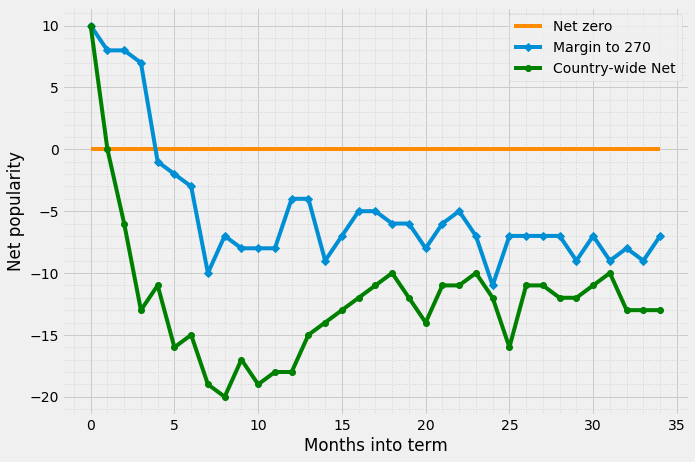

In [4]:
show_approval()

# Popularity Above Replacement President (PARP) 

Fivethirtyeight is a combination sports/politics site, and it has a lot of statistics about sports players and how much better they are than the average replacement player. Given that, they [decided](https://fivethirtyeight.com/features/the-states-where-trump-is-more-and-less-popular-than-he-should-be/) to rate the president's approval versus each state's overall approval of the president's party (in recent elections), which is a way of rating the president's performance versus an average replacement candidate from the same party. I'll duplicate that work and keep it up to date. We define the PARP for a state as the president's net approval minus the average party-member's net approval in that state (known as the "partisan lean").

Trump is much less popular than the average Republican. There are only three states where Trump is exceeding a replacement Republican (i.e., has a positive PARP): one deep-red southern state, Mississippi, and two deep-blue coastal states, Hawaii and Rhode Island (where he is deeply unpopular, but not as unpopular as other Republicans). Again, the swing states are **BOLD CAPITALIZED**.  

In the table below, states are ordered by PARP. In each row we have the state name followed by the partisan lean of the state (positive numbers lean towards the president's party), the electoral votes, and then a pair of statistics (PARP, and net approval (in parentheses)) for four time periods (today,  followed by January of 2019, 2018, and 2017). Trump was more popular than an average Republican at his inauguration in January 2017, with positive PARP in 42 states. But by 2018 he had positive PARP in only 6 states, and today only 3.

In [5]:
show_parp()

|State|Lean|EV|PARP|(Net)|PARP'19|(Net)|PARP'18|(Net)|PARP'17|(Net)|
|-|-|-|-|-|-|-|-|-|-|-|
|Mississippi|+15|6|+4|(+19)|-2|(+13)|+2|(+17)|+19|(+34)|
|Rhode Island|-26|4|+4|(-22)|+7|(-19)|+4|(-22)|+22|(-4)|
|Hawaii|-36|4|+1|(-35)|+7|(-29)|+0|(-36)|+23|(-13)|
|Massachusetts|-29|11|+0|(-29)|-2|(-31)|-3|(-32)|+25|(-4)|
|New Jersey|-13|14|-2|(-15)|-6|(-19)|-3|(-16)|+15|(+2)|
|New Mexico|-7|5|-2|(-9)|-11|(-18)|-13|(-20)|+24|(+17)|
|New York|-22|29|-3|(-25)|-2|(-24)|+4|(-18)|+30|(+8)|
|California|-24|55|-4|(-28)|-6|(-30)|+1|(-23)|+18|(-6)|
|Delaware|-14|3|-4|(-18)|-1|(-15)|+0|(-14)|+22|(+8)|
|**FLORIDA**|+5|29|-4|(+1)|-9|(-4)|+0|(+5)|+17|(+22)|
|Maryland|-23|10|-4|(-27)|-7|(-30)|+0|(-23)|+10|(-13)|
|Alabama|+27|9|-5|(+22)|-7|(+20)|+3|(+30)|+9|(+36)|
|Alaska|+15|3|-5|(+10)|-14|(+1)|-14|(+1)|+9|(+24)|
|Illinois|-13|20|-7|(-20)|-10|(-23)|-8|(-21)|+22|(+9)|
|Louisiana|+17|8|-7|(+10)|-2|(+15)|+2|(+19)|+14|(+31)|
|**NORTH CAROLINA**|+5|15|-7|(-2)|-9|(-4)|-6|(-1)|+13|(+18)|
|Virginia|+0|13|-7|(-7)|-10|(-10)|-4|(-4)|+8|(+8)|
|Maine|-5|4|-8|(-13)|-6|(-11)|-11|(-16)|+13|(+8)|
|Nevada|+1|6|-8|(-7)|-14|(-13)|-2|(-1)|+9|(+10)|
|Pennsylvania|+1|20|-8|(-7)|-11|(-10)|-4|(-3)|+9|(+10)|
|Kentucky|+23|8|-9|(+14)|-9|(+14)|-8|(+15)|+11|(+34)|
|South Carolina|+17|9|-9|(+8)|-9|(+8)|-10|(+7)|+8|(+25)|
|Connecticut|-11|7|-11|(-22)|-13|(-24)|-8|(-19)|+16|(+5)|
|Minnesota|-2|10|-11|(-13)|-16|(-18)|-12|(-14)|+5|(+3)|
|West Virginia|+30|5|-11|(+19)|-6|(+24)|-8|(+22)|+7|(+37)|
|Ohio|+7|18|-12|(-5)|-13|(-6)|-11|(-4)|+7|(+14)|
|Tennessee|+28|11|-12|(+16)|-16|(+12)|-11|(+17)|+5|(+33)|
|Wyoming|+47|3|-12|(+35)|-17|(+30)|-22|(+25)|-7|(+40)|
|**ARIZONA**|+9|11|-13|(-4)|-17|(-8)|-12|(-3)|+11|(+20)|
|Michigan|-1|16|-13|(-14)|-14|(-15)|-9|(-10)|+9|(+8)|
|Colorado|-1|9|-14|(-15)|-17|(-18)|-13|(-14)|+2|(+1)|
|**TEXAS**|+17|38|-14|(+3)|-17|(+0)|-10|(+7)|+3|(+20)|
|**GEORGIA**|+12|16|-15|(-3)|-14|(-2)|-5|(+7)|+6|(+18)|
|Oregon|-9|7|-15|(-24)|-13|(-22)|-11|(-20)|+11|(+2)|
|Wisconsin|+1|10|-15|(-14)|-17|(-16)|-13|(-12)|+5|(+6)|
|Arkansas|+24|6|-16|(+8)|-14|(+10)|-11|(+13)|+6|(+30)|
|**INDIANA**|+18|11|-16|(+2)|-14|(+4)|-17|(+1)|+4|(+22)|
|**MISSOURI**|+19|10|-16|(+3)|-21|(-2)|-17|(+2)|+0|(+19)|
|Idaho|+35|4|-17|(+18)|-20|(+15)|-24|(+11)|-6|(+29)|
|New Hampshire|+2|4|-17|(-15)|-21|(-19)|-12|(-10)|-1|(+1)|
|Washington|-12|12|-17|(-29)|-14|(-26)|-11|(-23)|+13|(+1)|
|Vermont|-24|3|-18|(-42)|-11|(-35)|-12|(-36)|+22|(-2)|
|District of Columbia|-43|3|-19|(-62)|-22|(-65)|-21|(-64)|+12|(-31)|
|Iowa|+6|6|-19|(-13)|-20|(-14)|-16|(-10)|+3|(+9)|
|**MONTANA**|+18|3|-19|(-1)|-17|(+1)|-18|(+0)|+6|(+24)|
|**KANSAS**|+23|6|-20|(+3)|-22|(+1)|-18|(+5)|+1|(+24)|
|Oklahoma|+34|7|-25|(+9)|-24|(+10)|-19|(+15)|+0|(+34)|
|**SOUTH DAKOTA**|+31|3|-28|(+3)|-25|(+6)|-21|(+10)|-10|(+21)|
|**NEBRASKA**|+24|5|-29|(-5)|-24|(+0)|-18|(+6)|-1|(+23)|
|**UTAH**|+31|6|-29|(+2)|-37|(-6)|-34|(-3)|-4|(+27)|
|**NORTH DAKOTA**|+33|3|-31|(+2)|-29|(+4)|-22|(+11)|-10|(+23)|